![](https://pm4py.fit.fraunhofer.de/static/assets/images/pm4py-site-logo-padded.png)

# <b>Introduction<b>

<span style="font-size:larger;"><b>Process:</b>

By process we mean a collection of discrete events (activities) in order to achieve a certain goal.

<br>

<span style="font-size:larger;"><b>Process mining:</b>

A set of techniques used for obtaining knowledge of and extracting insights from processes by the means of analyzing the event data, generated during the execution of the process. The end goal of process mining is to discover, model, monitor, and optimize the underlying processes.

<br>

<span style="font-size:larger;"><b>Potential benefits of process mining:</b>

- Process discovery — Converting an event log into a process model.
- Conformance checking — Investigating the differences between the model and what happens in real life. This way the companies can identify deviations from the model and determine their severity/cost.
- Throughput analysis/bottleneck detection — Accounting for the intensity of events’ execution (measured by time spent to complete a particular event) in order to determine potential bottlenecks. This kind of analysis can be used to improve time-related KPIs by minimizing throughput/overhead time.

<br>

<span style="font-size:larger;"><b>Event log:</b>

In order to carry out process mining, a dataset must contain (at least) the following 3 types of information:
- Case ID — A unique identifier of an entity going through the process. A common example could be the user’s unique ID, although, many possibilities are valid (it depends on the use case).
- Event — A step of the process, any activity that is a part of the process being analyzed.
- Timestamp — Used for performance evaluation and determining the order of events, can be the time when the user entered/exited the given event (or both actually).

<br>

<span style="font-size:larger;"><b>Petri net:</b>

A Petri net - also known as a place/transition (PT) net - consists of _places_, _transitions_, and _arcs_ (a.k.a. _flow relations_). Arcs run from a place to a transition or vice versa, never between places or between transitions. The places from which an arc runs to a transition are called the input places of the transition; the places to which arcs run from a transition are called the output places of the transition. 

# <b>1. Setup</b>

## <b>1.1. Packages</b>

In [1]:
# python ######################################################################
import sys
import os
import datetime

# basics ######################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# widgets #####################################################################
import ipywidgets as widgets
from ipywidgets import interact

# process mining ##############################################################
import pm4py

# object.log
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer

# object.conversion
from pm4py.objects.conversion.dfg import converter as dfg_converter
from pm4py.objects.conversion.process_tree import converter as pt_converter

# algo.discovery
from pm4py.algo.discovery.alpha import variants
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.correlation_mining import algorithm as correlation_miner
from pm4py.visualization.dfg import visualizer as dfg_visualizer

# algo.conformance
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

# vizualization
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# util
from pm4py.util import vis_utils

# Define directories
from src import SRC_DIR

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'seaborn'

In [2]:
from src import SRC_DIR

In [3]:
str(SRC_DIR)

'D:\\MyFiles\\Courses\\00_MyCourses\\ProcessMining\\00_Resources\\PythonScripts\\src'

<br></br>
## <b>1.2. Environment and Versions</b>

In [17]:
print(f'platform:     {sys.platform}')
print(f'environment:  {sys.prefix}')
print(f'python:       {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')


package_versions = [
        ['pandas', pd.__version__], 
        ['numpy ', np.__version__], 
        ['matplotlib', sys.modules['matplotlib'].__version__], 
        ['seaborn', sns.__version__],
        ['ipywidgets', sys.modules['ipywidgets'].__version__],
        ['pm4py', pm4py.__version__],
]

pd.DataFrame(package_versions, columns = ['package', 'version'])

platform:     linux
environment:  /home/kourosh/anaconda3/envs/TehranData
python:       3.10.14


,package,version
0,pandas,1.5.3
1,numpy,1.23.5
2,matplotlib,3.9.0
3,seaborn,0.13.2
4,ipywidgets,8.1.3
5,pm4py,2.7.11.11


<br><br>
## <b>1.3. Setting</b>

In [21]:
pd.set_option('display.max_rows', 10)

In [22]:
sns.set_theme()

<br></br>
## <b>1.4. Functions</b>

In [211]:
def dfg_performance_matrix(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str, 
    duration: str ='h'
) -> pd.DataFrame:

    """
    Return a directly-follows graph duration matrix based on the traces in the event log.
    Row events (i.e. the index) are events 'from' and column events are the events 'to'.
    By default duration is set to hours (h). Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    # event log
    log = event_log[[case_var, event_var, timestamp_var]]
    
    # initiate matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for group in groups:
        event = group[1].sort_values(timestamp_var)\
                        .rename(columns = {event_var:'event_from', timestamp_var:'time_begin'})

        event['event_to'] = event['event_from'].shift(-1)
        event['time_end'] = event['time_begin'].shift(-1)
        event['duration'] = (event['time_end'] - event['time_begin']) / np.timedelta64(1, duration)
        event.dropna(inplace = True)
        
        # loop through traces
        for row in event.itertuples(index = False):
            matrix.at[row.event_from, row.event_to] = np.nansum([matrix.at[row.event_from, row.event_to], row.duration])
    
    return matrix.astype(float)

In [212]:
def dfg_frequency_matrix(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str
) -> pd.DataFrame:
    
    """
    Return a directly-follows graph frequency matrix based on the traces in the event log.
    Row events (i.e. the index) are events 'from' and column events are the events 'to'.
    """
    
    # event log
    log = event_log[[case_var, event_var, timestamp_var]]
    
    # initiate matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events).fillna(0)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for name, group in groups:
        event = group.sort_values(timestamp_var)\
                     .drop([case_var, timestamp_var], axis = 1)\
                     .rename(columns = {event_var:'event_from'})

        event['event_to'] = event['event_from'].shift(-1)
        event.dropna(inplace = True)
        
        # loop through traces
        for transition in event.itertuples(index = False):
            matrix.at[transition.event_from, transition.event_to] += 1

    return matrix.replace(0, np.nan)

In [213]:
def frequency_table(dfg_frequency_matrix: pd.DataFrame) -> pd.DataFrame:
    
    """
    Returns an directly-follows graph frequency table
    """
    
    arcs = list()
    
    for row in dfg_frequency_matrix.index:
        for col in dfg_frequency_matrix.columns:
            if not np.isnan(dfg_frequency_matrix.at[row, col]):
                arcs.append((row, col, dfg_frequency_matrix.at[row, col]))
    
    arc_freq = pd.DataFrame(arcs, columns = ['event_from', 'event_to', 'frequency'])\
    .set_index(['event_from', 'event_to'])
    
    return arc_freq

In [246]:
def my_func(name='Kourosh'):
    return f'Hello {name}'

In [248]:
my_func(name=5)

'Hello 5'

In [239]:
a

'Hello {1: 2}'

In [252]:
def activity_duration(
    event_log: pd.DataFrame,
    case_var: str,
    event_var: str,
    timestamp_var: str,
    duration_type: str ='h'
) -> pd.DataFrame:
    
    """
    Returns a dataframe with activity durations (i.e. 'arc' performance decorators).
    By default duration_type is set to hours (h).
    Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    event_log = event_log.rename(columns = {event_var: 'event_from',
                                            timestamp_var: 'time_from'})

    dfs_list = []
    groups = event_log.groupby(case_var)
    for name, group in groups:
        arc = group.sort_values('time_from')
        arc['event_to'] = arc['event_from'].shift(-1)
        arc['time_to'] = arc['time_from'].shift(-1)
        arc.dropna(inplace = True)
        duration_var = f'duration ({duration_type})'
        arc[duration_var] = (arc['time_to'] - arc['time_from']) / np.timedelta64(1, duration_type)
        
        dfs_list.append(arc[[case_var, 'event_from', 'event_to', 'time_from', 'time_to', duration_var]])

    return pd.concat(dfs_list).set_index(case_var)

<br></br>
# <b>2. Data Prepatation</b>

## <b>2.1. Read Data</b>

In [39]:
log_csv = pd.read_csv(SRC_DIR / 'Datasets' / 'Example' / 'Running_Example' / 'running-example.csv', sep=';')
log_csv.head()

,case_id,activity,timestamp,costs,resource
0,3,register request,2010-12-30 14:32:00+01:00,50,Pete
1,3,examine casually,2010-12-30 15:06:00+01:00,400,Mike
2,3,check ticket,2010-12-30 16:34:00+01:00,100,Ellen
3,3,decide,2011-01-06 09:18:00+01:00,200,Sara
4,3,reinitiate request,2011-01-06 12:18:00+01:00,200,Sara


In [40]:
log_csv.shape

(42, 5)

In [41]:
log_csv.dtypes

case_id       int64
activity     object
timestamp    object
costs         int64
resource     object
dtype: object

<br></br>
## <b>2.2. Convert Data</b>

In [42]:
log_csv['timestamp'] = pd.to_datetime(log_csv['timestamp'])
log_csv.dtypes

case_id                                     int64
activity                                   object
timestamp    datetime64[ns, pytz.FixedOffset(60)]
costs                                       int64
resource                                   object
dtype: object

In [44]:
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
log_csv.head()

,case_id,activity,timestamp,costs,resource
0,3,register request,2010-12-30 13:32:00+00:00,50,Pete
1,3,examine casually,2010-12-30 14:06:00+00:00,400,Mike
2,3,check ticket,2010-12-30 15:34:00+00:00,100,Ellen
3,3,decide,2011-01-06 08:18:00+00:00,200,Sara
4,3,reinitiate request,2011-01-06 11:18:00+00:00,200,Sara


In [45]:
log_csv.dtypes

case_id                    int64
activity                  object
timestamp    datetime64[ns, UTC]
costs                      int64
resource                  object
dtype: object

<br></br>
## <b>2.3. Explore Data</b>

### <b>2.3.1. Shape</b>

In [46]:
log_csv.shape

(42, 5)

<br></br>
### <b>2.3.2. Check NA-Values</b>

In [48]:
log_csv.isna().sum()

case_id      0
activity     0
timestamp    0
costs        0
resource     0
dtype: int64

<br></br>
### <b>2.3.3. Event Log Info</b>

In [18]:
log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   case_id    42 non-null     int64              
 1   activity   42 non-null     object             
 2   timestamp  42 non-null     datetime64[ns, UTC]
 3   costs      42 non-null     int64              
 4   resource   42 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 1.8+ KB


<br></br>
### <b>2.3.4. Get Sample Data</b>

In [52]:
log_csv.sample(frac=.1)

,case_id,activity,timestamp,costs,resource
27,5,decide,2011-01-10 12:28:00+00:00,200,Sara
11,2,examine casually,2010-12-30 13:16:00+00:00,400,Sean
38,4,check ticket,2011-01-07 11:06:00+00:00,100,Mike
14,1,register request,2010-12-30 10:02:00+00:00,50,Pete


<br></br>
### <b>2.3.5. Get Unique Values</b>

In [134]:
pd.DataFrame(
    {
        'variable': log_csv.columns, 
        'unique values': [log_csv[col].nunique() for col in log_csv.columns],
        'fraction': [round(log_csv[col].nunique() / log_csv.shape[0], 2) for col in log_csv.columns], 
    }
).set_index('variable')

,unique values,fraction
variable,,
case_id,6,0.14
activity,8,0.19
timestamp,41,0.98
costs,4,0.10
resource,6,0.14


<br></br>
### <b>2.3.6. Visualizing Event Counts by Case ID</b>

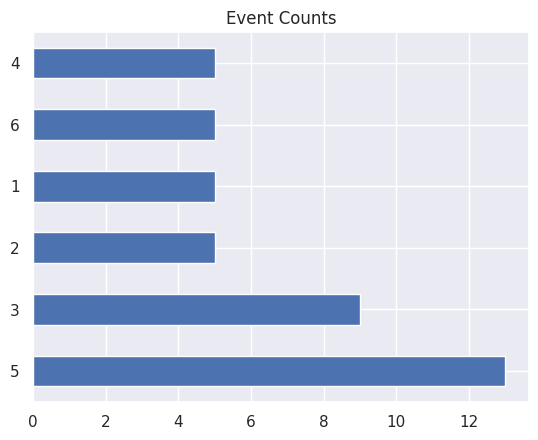

In [136]:
log_csv['case_id'].value_counts().plot(y='case_id', kind='barh', title='Event Counts')
plt.show()

<br></br>
### <b>2.3.7. Visualizing Event Counts</b>

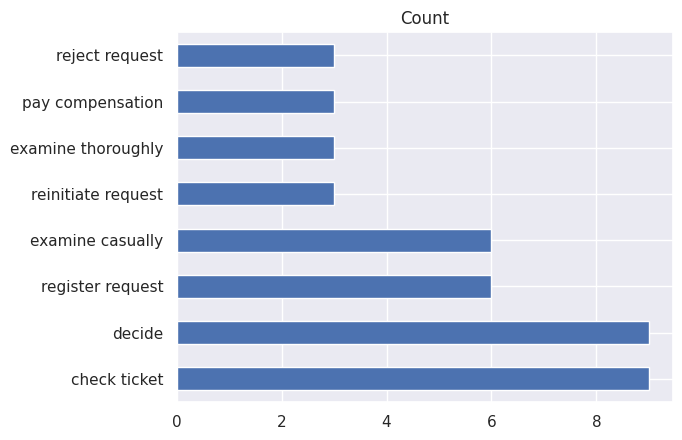

In [138]:
log_csv['activity'].value_counts().plot(y='activity', kind='barh', title='Count')
plt.show()

<br></br>
### <b>2.3.8. Visualizing Event Counts by Resources</b>

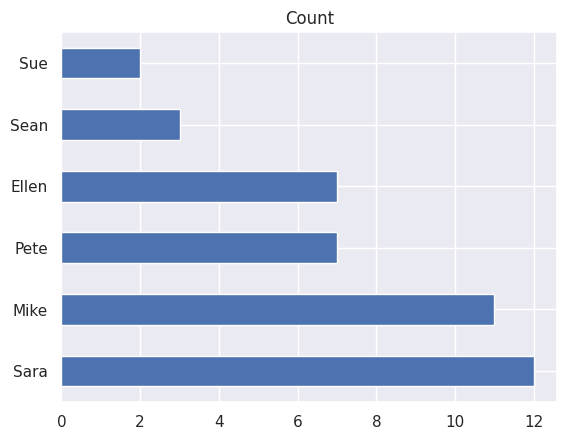

In [139]:
log_csv['resource'].value_counts().plot(y='resource', kind='barh', title='Count')
plt.show()

<br></br>
### <b>2.3.9. Unique Dates</b>

In [144]:
log_csv['timestamp'].dt.date.nunique()

18

In [145]:
# Multiple occurences: timestamp
pd.DataFrame(log_csv['timestamp'].dt.date.value_counts()).head(5)

,timestamp
2011-01-06,8
2010-12-30,7
2011-01-07,5
2011-01-08,4
2011-01-09,2


<br></br>
### <b>2.3.10. Costs Boxplot</b>

In [148]:
log_csv

,case_id,activity,timestamp,costs,resource
0,3,register request,2010-12-30 13:32:00+00:00,50,Pete
1,3,examine casually,2010-12-30 14:06:00+00:00,400,Mike
2,3,check ticket,2010-12-30 15:34:00+00:00,100,Ellen
3,3,decide,2011-01-06 08:18:00+00:00,200,Sara
4,3,reinitiate request,2011-01-06 11:18:00+00:00,200,Sara
...,...,...,...,...,...
37,4,register request,2011-01-06 14:02:00+00:00,50,Pete
38,4,check ticket,2011-01-07 11:06:00+00:00,100,Mike
39,4,examine thoroughly,2011-01-08 13:43:00+00:00,400,Sean
40,4,decide,2011-01-09 11:02:00+00:00,200,Sara


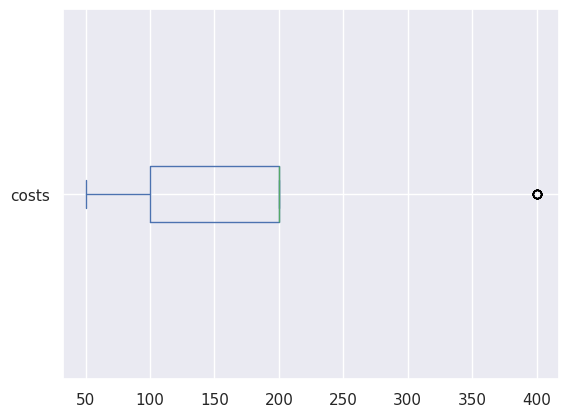

In [147]:
log_csv['costs'].plot(kind='box', vert=False)
plt.show()

<Axes: >

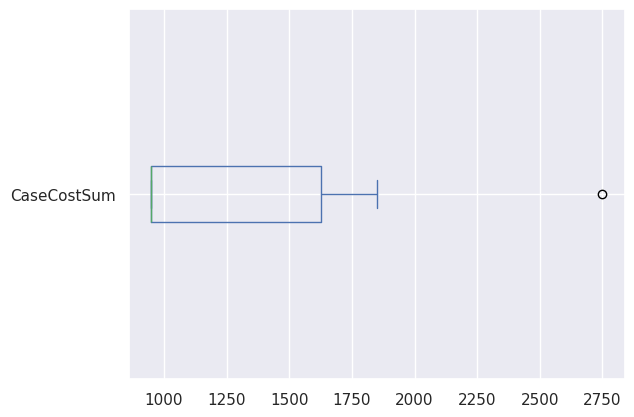

In [208]:
case_df = log_csv.groupby('case_id').agg(CaseCostSum=('costs', 'sum'))

case_df['CaseCostSum'].plot(kind='box', vert=False)

<br></br>
### <b>2.3.11. Boxplots of Activities Duration</b>

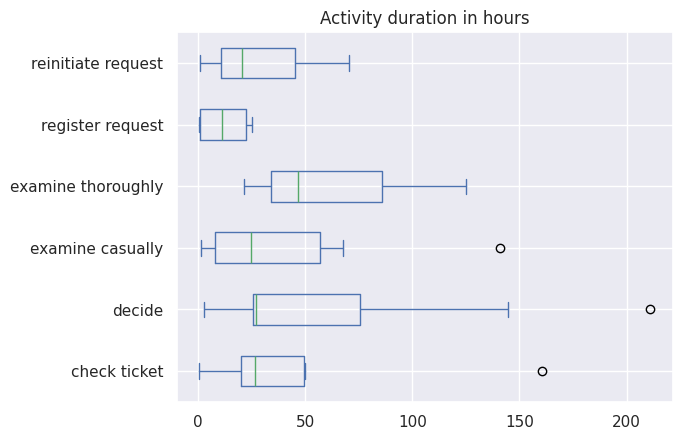

In [263]:
ad_df = activity_duration(log_csv, 'case_id', 'activity', 'timestamp')
ad_df = ad_df[['event_from', 'event_to', 'duration (h)']].reset_index()
ad_df = ad_df.pivot(columns='event_from', values='duration (h)')
ad_df.plot(kind='box', vert=False, title='Activity duration in hours')
plt.show()

<br></br>
### <b>2.3.12. Activity Timeline Per Trace</b>

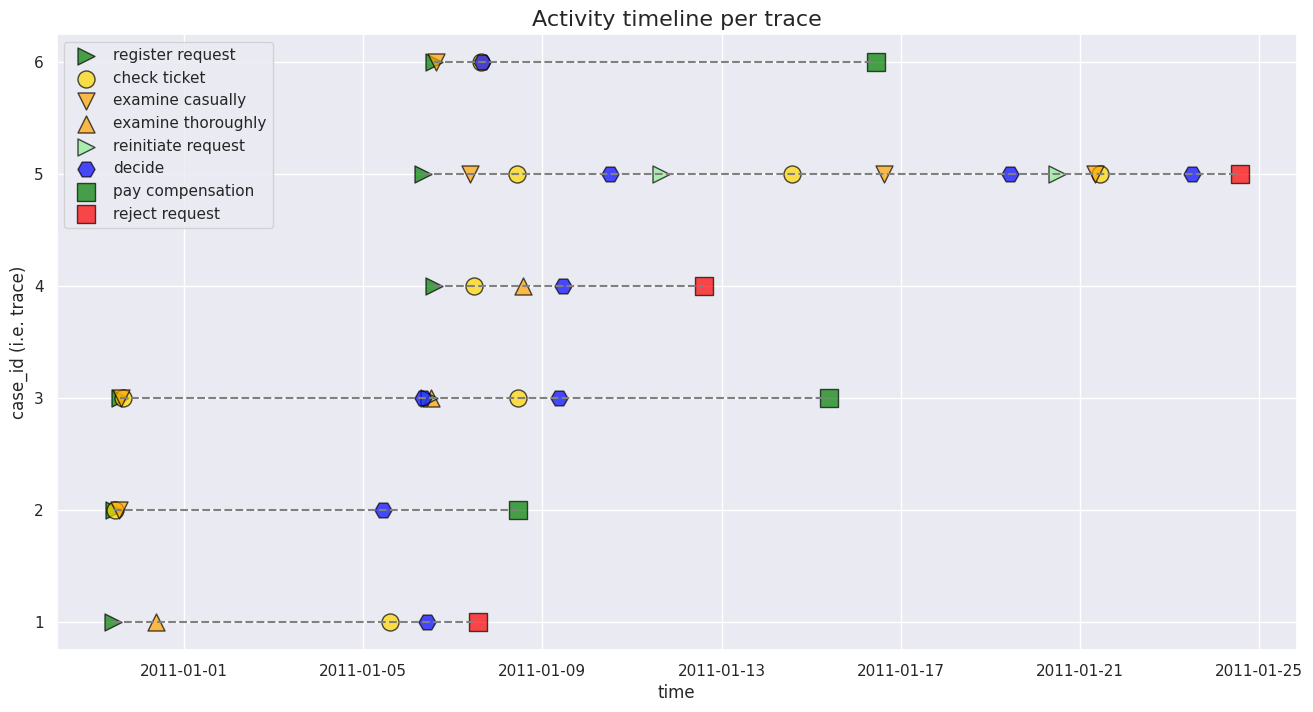

In [264]:
# Settings
activity = {
    'register request': ('>', 'green'), 
    'check ticket': ('o', 'gold'), 
    'examine casually': ('v', 'orange'), 
    'examine thoroughly': ('^', 'orange'), 
    'reinitiate request': ('>', 'lightgreen'), 
    'decide': ('H', 'blue'), 
    'pay compensation': ('s', 'green'), 
    'reject request': ('s', 'red'),
}


# Figure
fig, ax = plt.subplots(figsize=(16, 8))


# Timelines
log_csv_agg_by_case = log_csv.groupby('case_id').agg(
    time_start = ('timestamp', min),
    time_end = ('timestamp', max)).reset_index()
log_csv_agg_by_case

for timeline in log_csv_agg_by_case.itertuples(index=False):
    plt.hlines(timeline.case_id, timeline.time_start, timeline.time_end, 
               colors = 'grey', linestyles = 'dashed')

# Activities
for act in activity.keys():
    ax.scatter(log_csv.loc[log_csv.activity == act, 'timestamp'], 
               log_csv.loc[log_csv.activity == act, 'case_id'],
               marker = activity[act][0],
               color = activity[act][1], 
               s = 150, 
               alpha = .7,
               label = act,
               edgecolors = 'black',
              )

ax.set_title('Activity timeline per trace', fontsize=16)
ax.set_xlabel('time')
ax.set_ylabel('case_id (i.e. trace)')
ax.legend()
ax.grid(True)

plt.show()

<br></br>
### <b>2.3.13. Frequency Table</b>

In [268]:
frequencey_matrix = dfg_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp')
af_df = frequency_table(frequencey_matrix).reset_index()
af_df

,event_from,event_to,frequency
0,register request,examine casually,3.0
1,register request,check ticket,2.0
2,register request,examine thoroughly,1.0
3,examine casually,check ticket,4.0
4,examine casually,decide,2.0
...,...,...,...
11,reinitiate request,examine casually,1.0
12,reinitiate request,check ticket,1.0
13,reinitiate request,examine thoroughly,1.0
14,examine thoroughly,check ticket,2.0


<br></br>
### <b>2.3.14. Extract Activities Duration From Events</b>

In [269]:
ad_df = activity_duration(log_csv, 'case_id', 'activity', 'timestamp')

ad_df = ad_df.groupby(['event_from', 'event_to']).agg(
    mean_duration = ('duration (h)', 'mean')
).reset_index()
ad_df

,event_from,event_to,mean_duration
0,check ticket,decide,50.544444
1,check ticket,examine casually,25.675000
2,check ticket,examine thoroughly,26.616667
3,decide,pay compensation,142.822222
4,decide,reinitiate request,18.444444
...,...,...,...
11,register request,examine casually,8.955556
12,register request,examine thoroughly,23.066667
13,reinitiate request,check ticket,70.250000
14,reinitiate request,examine casually,20.300000


<br></br>
### <b>2.3.15. Frequency-Duration Table</b>

In [271]:
ad_df = activity_duration(log_csv, 'case_id', 'activity', 'timestamp')

ad_df = ad_df.groupby(by = ['event_from', 'event_to']).agg(
    mean_duration = ('duration (h)', 'mean'),
    total_duration = ('duration (h)', 'sum'),
    std_duration = ('duration (h)', 'std'),
    count = ('event_from', 'count')
).reset_index()

ad_df

,event_from,event_to,mean_duration,total_duration,std_duration,count
0,check ticket,decide,50.544444,303.266667,57.231699,6
1,check ticket,examine casually,25.675000,51.350000,33.387225,2
2,check ticket,examine thoroughly,26.616667,26.616667,NaN,1
3,decide,pay compensation,142.822222,428.466667,69.121946,3
4,decide,reinitiate request,18.444444,55.333333,13.391885,3
...,...,...,...,...,...,...
11,register request,examine casually,8.955556,26.866667,14.099186,3
12,register request,examine thoroughly,23.066667,23.066667,NaN,1
13,reinitiate request,check ticket,70.250000,70.250000,NaN,1
14,reinitiate request,examine casually,20.300000,20.300000,NaN,1


<br></br>
### <b>2.3.16. Frequency Table Heatmap</b>

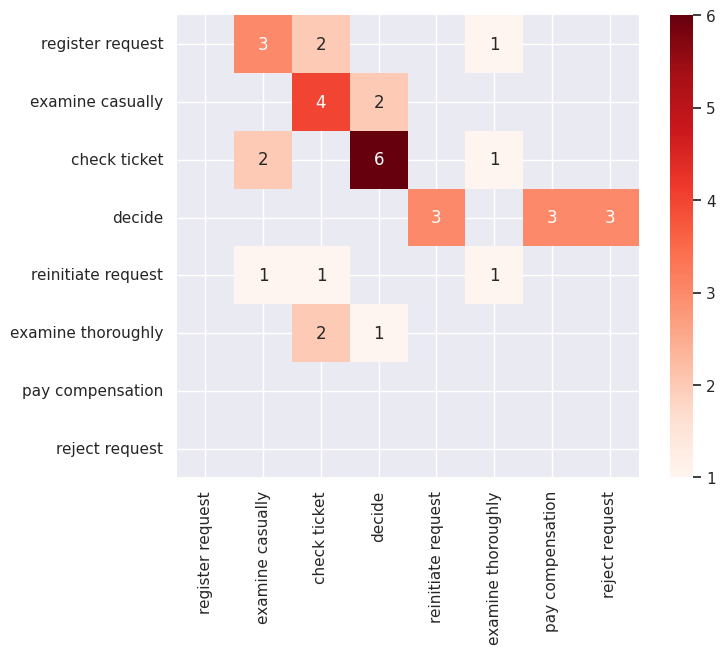

In [274]:
dfg_freq_matrix = dfg_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp')
sns.set(rc={'figure.figsize':(8, 6)})
sns.heatmap(dfg_freq_matrix, annot=True, fmt='.0f', cmap='Reds', square=True)
plt.show()

<br></br>
### <b>2.3.17. Activities Duration Heatmap</b>

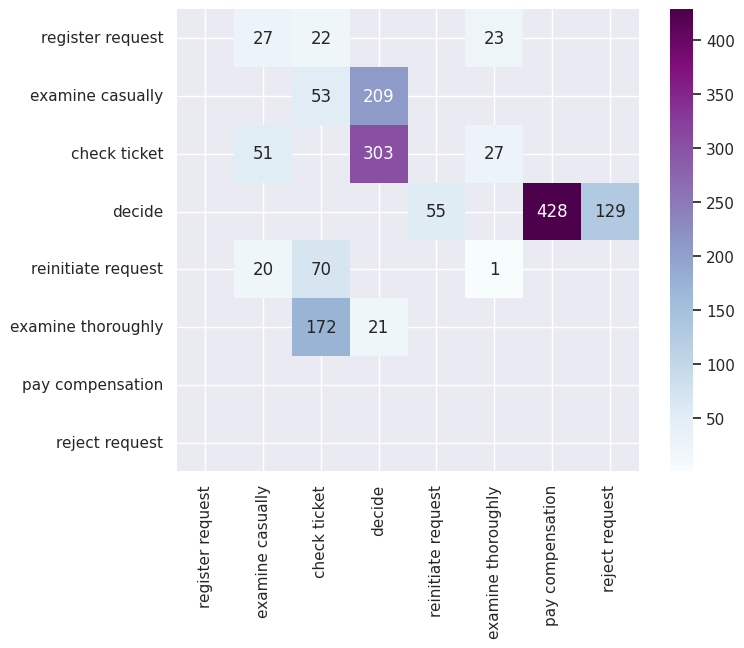

In [277]:
# Directly-Follows Graph total duration heapmap (in hours)
dfg_perf_matrix = dfg_performance_matrix(log_csv, 'case_id', 'activity', 'timestamp', duration='h')
sns.set(rc={'figure.figsize':(8, 6)})
sns.heatmap(dfg_perf_matrix, annot=True, fmt='.0f', cmap='BuPu', square=True)
plt.show()

<br></br>
### <b>2.3.18. Performance Spectrum</b>

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

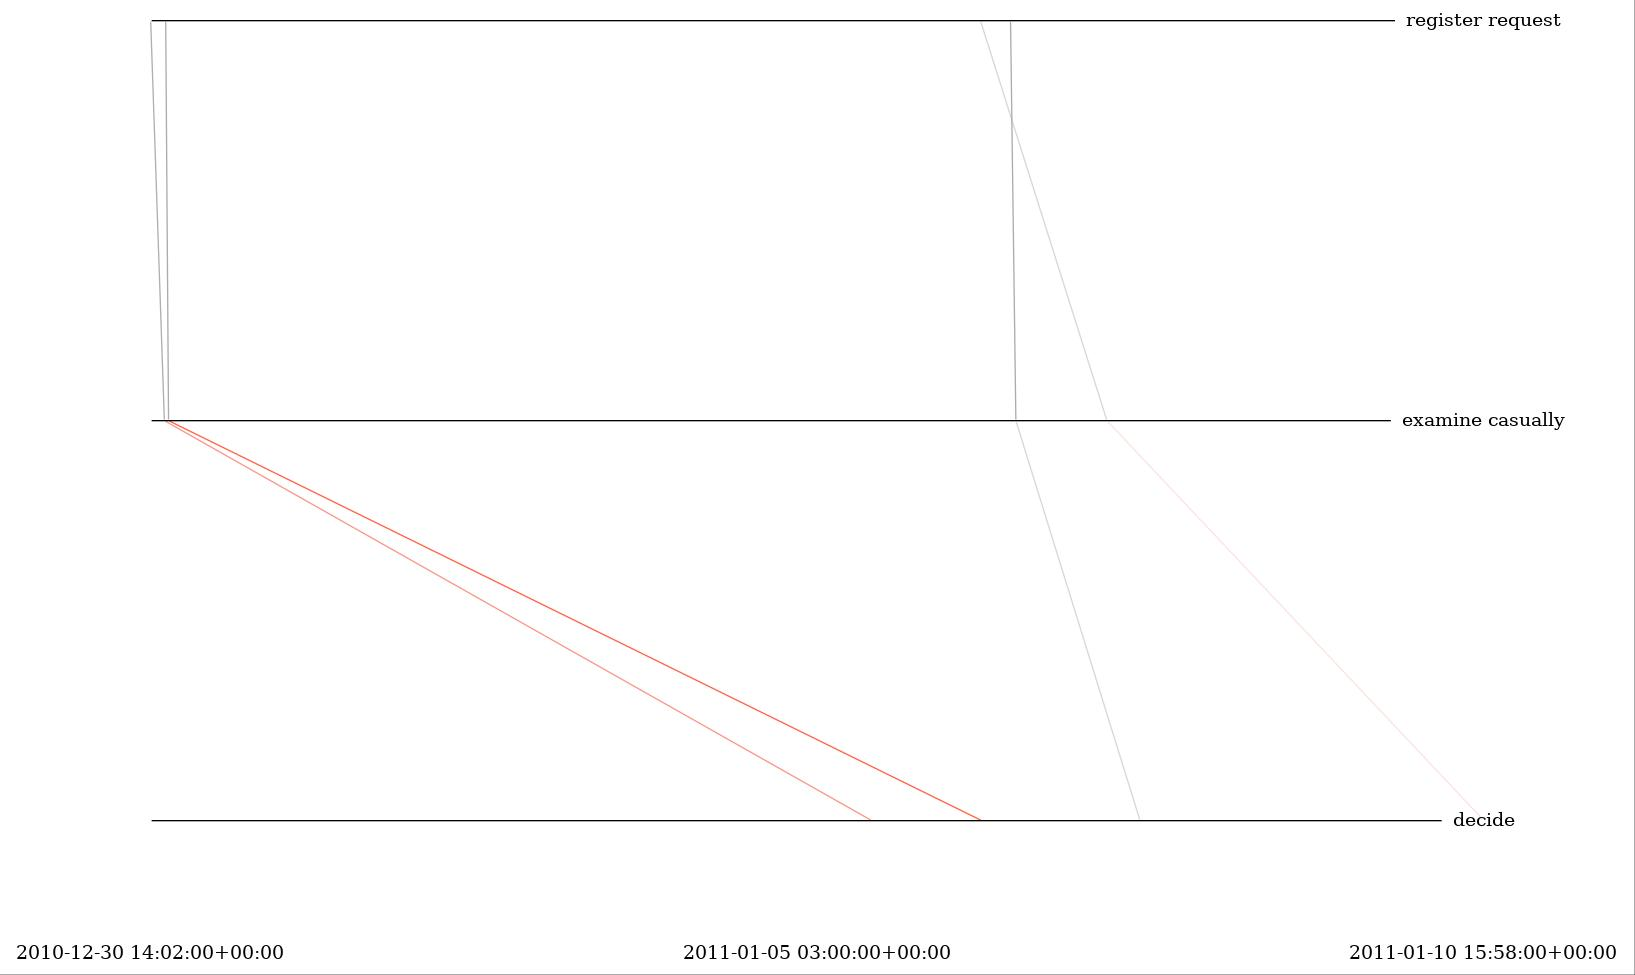

In [35]:
log = xes_importer.apply(str(SRC_DIR / 'Datasets' / 'Example' / 'Running_Example' / 'running-example.xes'))
pm4py.view_performance_spectrum(log, ["register request", "examine casually", "decide"], format="jpg")

<br></br>
# <b>3. Event Log</b>

## <b>3.1. Create pm4py Event Log Object From Pandas Dataframe<b>

In [278]:
log_csv.head()

,case_id,activity,timestamp,costs,resource
0,3,register request,2010-12-30 13:32:00+00:00,50,Pete
1,3,examine casually,2010-12-30 14:06:00+00:00,400,Mike
2,3,check ticket,2010-12-30 15:34:00+00:00,100,Ellen
3,3,decide,2011-01-06 08:18:00+00:00,200,Sara
4,3,reinitiate request,2011-01-06 11:18:00+00:00,200,Sara


In [279]:
event_log = pm4py.format_dataframe(
    log_csv,
    case_id = 'case_id',
    activity_key = 'activity',
    timestamp_key = 'timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
)

<br></br>
## <b>3.2. View Event Log</b>

In [281]:
event_log.head()

,case_id,activity,timestamp,costs,resource,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,1,register request,2010-12-30 10:02:00+00:00,50,Pete,1,register request,2010-12-30 10:02:00+00:00,0,0
1,1,examine thoroughly,2010-12-31 09:06:00+00:00,400,Sue,1,examine thoroughly,2010-12-31 09:06:00+00:00,1,0
2,1,check ticket,2011-01-05 14:12:00+00:00,100,Mike,1,check ticket,2011-01-05 14:12:00+00:00,2,0
3,1,decide,2011-01-06 10:18:00+00:00,200,Sara,1,decide,2011-01-06 10:18:00+00:00,3,0
4,1,reject request,2011-01-07 13:24:00+00:00,200,Pete,1,reject request,2011-01-07 13:24:00+00:00,4,0


In [39]:
# View Start and End activities

start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)

print(f'Start activities: {start_activities}')
print(f'End activities  : {end_activities}')

Start activities: {'register request': 6}
End activities  : {'reject request': 3, 'pay compensation': 3}


<br></br>
## <b>3.3. Export Event Log (to XES)</b>

In [40]:
type(event_log)

pandas.core.frame.DataFrame

In [285]:
xes_exporter.apply(event_log, str(SRC_DIR / 'Datasets' / 'Example' / 'Running_Example' / 'running-example.xes'))

exporting log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

<br></br>
## <b>3.4. Import Event Log (from XES)</b>

In [286]:
log = xes_importer.apply(str(SRC_DIR / 'Datasets' / 'Example' / 'Running_Example' / 'running-example.xes'))

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

<br></br>
## <b>3.5. Explore Event Log (XES)</b>

In [287]:
type(log)

pm4py.objects.log.obj.EventLog

In [44]:
type(log[0])

pm4py.objects.log.obj.Trace

In [45]:
type(log[0][0])

pm4py.objects.log.obj.Event

In [46]:
for trace in log:
    print(trace)
    break

print('-' * 70)
    
for event in trace:
    print(event)    
    break

{'attributes': {'concept:name': '1'}, 'events': [{'case_id': 1, 'activity': 'register request', 'timestamp': datetime.datetime(2010, 12, 30, 10, 2, tzinfo=datetime.timezone.utc), 'costs': 50, 'resource': 'Pete', 'concept:name': 'register request', 'time:timestamp': datetime.datetime(2010, 12, 30, 10, 2, tzinfo=datetime.timezone.utc), '@@index': 0, '@@case_index': 0}, '..', {'case_id': 1, 'activity': 'reject request', 'timestamp': datetime.datetime(2011, 1, 7, 13, 24, tzinfo=datetime.timezone.utc), 'costs': 200, 'resource': 'Pete', 'concept:name': 'reject request', 'time:timestamp': datetime.datetime(2011, 1, 7, 13, 24, tzinfo=datetime.timezone.utc), '@@index': 4, '@@case_index': 0}]}
----------------------------------------------------------------------
{'case_id': 1, 'activity': 'register request', 'timestamp': datetime.datetime(2010, 12, 30, 10, 2, tzinfo=datetime.timezone.utc), 'costs': 50, 'resource': 'Pete', 'concept:name': 'register request', 'time:timestamp': datetime.datetime(2

In [288]:
# concept:name (i.e. case_id) for each trace

for trace in log:
    print(trace.attributes)

{'concept:name': '1'}
{'concept:name': '2'}
{'concept:name': '3'}
{'concept:name': '4'}
{'concept:name': '5'}
{'concept:name': '6'}


In [310]:
# Overview traces from XES
for trace in log:
    print(f"== TRACE: {trace.attributes['concept:name']} ==================================================")
    for event in trace:
        print('{:>18}:  {:>4}  |  {:>5}  |  {}  |  {:>2}'.format(
            event.get('concept:name'), 
            event.get('costs'), 
            event.get('resource'), 
            event.get('time:timestamp').strftime('%Y-%m-%d %H:%M'), 
            event.get('@@index')
        ))

== TRACE: 1 ==================================================
  register request:    50  |   Pete  |  2010-12-30 10:02  |   0
examine thoroughly:   400  |    Sue  |  2010-12-31 09:06  |   1
      check ticket:   100  |   Mike  |  2011-01-05 14:12  |   2
            decide:   200  |   Sara  |  2011-01-06 10:18  |   3
    reject request:   200  |   Pete  |  2011-01-07 13:24  |   4
== TRACE: 2 ==================================================
  register request:    50  |   Mike  |  2010-12-30 10:32  |   5
      check ticket:   100  |   Mike  |  2010-12-30 11:12  |   6
  examine casually:   400  |   Sean  |  2010-12-30 13:16  |   7
            decide:   200  |   Sara  |  2011-01-05 10:22  |   8
  pay compensation:   200  |  Ellen  |  2011-01-08 11:05  |   9
== TRACE: 3 ==================================================
  register request:    50  |   Pete  |  2010-12-30 13:32  |  10
  examine casually:   400  |   Mike  |  2010-12-30 14:06  |  11
      check ticket:   100  |  Ellen  |  201

<br></br>
## <b>3.6. Filter Event Log</b>

### <b>3.6.1. Filter on End Activity</b>

In [49]:
pay_compensation = pm4py.filter_end_activities(log, {'pay compensation'})
pay_compensation

[{'attributes': {'concept:name': '2'}, 'events': [{'case_id': 2, 'activity': 'register request', 'timestamp': datetime.datetime(2010, 12, 30, 10, 32, tzinfo=datetime.timezone.utc), 'costs': 50, 'resource': 'Mike', 'concept:name': 'register request', 'time:timestamp': datetime.datetime(2010, 12, 30, 10, 32, tzinfo=datetime.timezone.utc), '@@index': 5, '@@case_index': 1}, '..', {'case_id': 2, 'activity': 'pay compensation', 'timestamp': datetime.datetime(2011, 1, 8, 11, 5, tzinfo=datetime.timezone.utc), 'costs': 200, 'resource': 'Ellen', 'concept:name': 'pay compensation', 'time:timestamp': datetime.datetime(2011, 1, 8, 11, 5, tzinfo=datetime.timezone.utc), '@@index': 9, '@@case_index': 1}]}, '....', {'attributes': {'concept:name': '6'}, 'events': [{'case_id': 6, 'activity': 'register request', 'timestamp': datetime.datetime(2011, 1, 6, 14, 2, tzinfo=datetime.timezone.utc), 'costs': 50, 'resource': 'Mike', 'concept:name': 'register request', 'time:timestamp': datetime.datetime(2011, 1, 6

In [50]:
# Traces (i.e. case_id) that has activity 'pay compensation'

for trace in pay_compensation:
    print(trace.attributes['concept:name'])

2
3
6


In [51]:
# Convert Filtered Event Log to Pandas Dataframe

pm4py.convert_to_dataframe(pay_compensation)

,case_id,activity,timestamp,costs,resource,concept:name,time:timestamp,@@index,@@case_index,case:concept:name
0,2,register request,2010-12-30 10:32:00+00:00,50,Mike,register request,2010-12-30 10:32:00+00:00,5,1,2
1,2,check ticket,2010-12-30 11:12:00+00:00,100,Mike,check ticket,2010-12-30 11:12:00+00:00,6,1,2
2,2,examine casually,2010-12-30 13:16:00+00:00,400,Sean,examine casually,2010-12-30 13:16:00+00:00,7,1,2
3,2,decide,2011-01-05 10:22:00+00:00,200,Sara,decide,2011-01-05 10:22:00+00:00,8,1,2
4,2,pay compensation,2011-01-08 11:05:00+00:00,200,Ellen,pay compensation,2011-01-08 11:05:00+00:00,9,1,2
5,3,register request,2010-12-30 13:32:00+00:00,50,Pete,register request,2010-12-30 13:32:00+00:00,10,2,3
6,3,examine casually,2010-12-30 14:06:00+00:00,400,Mike,examine casually,2010-12-30 14:06:00+00:00,11,2,3
7,3,check ticket,2010-12-30 15:34:00+00:00,100,Ellen,check ticket,2010-12-30 15:34:00+00:00,12,2,3
8,3,decide,2011-01-06 08:18:00+00:00,200,Sara,decide,2011-01-06 08:18:00+00:00,13,2,3
9,3,reinitiate request,2011-01-06 11:18:00+00:00,200,Sara,reinitiate request,2011-01-06 11:18:00+00:00,14,2,3


<br></br>
### <b>3.6.2. Filtering Traces That Have Started and Ended in Sepecific Time</b>

In [52]:
start_datetime = datetime.datetime(2011, 1, 1, 0, 0, 0, 0)
end_datetime = datetime.datetime(2011, 12, 31, 23, 59, 59, 999999)
log_2011 = pm4py.filter_time_range(log, start_datetime, end_datetime, mode='traces_contained')

In [53]:
# Names of filtered case_ids (traces)

for trace in log_2011:
    print(trace.attributes['concept:name'])

4
5
6


In [54]:
# Convert Filtered Event Log to Pandas Dataframe

pm4py.convert_to_dataframe(log_2011).head()

,case_id,activity,timestamp,costs,resource,concept:name,time:timestamp,@@index,@@case_index,case:concept:name
0,4,register request,2011-01-06 14:02:00+00:00,50,Pete,register request,2011-01-06 14:02:00+00:00,19,3,4
1,4,check ticket,2011-01-07 11:06:00+00:00,100,Mike,check ticket,2011-01-07 11:06:00+00:00,20,3,4
2,4,examine thoroughly,2011-01-08 13:43:00+00:00,400,Sean,examine thoroughly,2011-01-08 13:43:00+00:00,21,3,4
3,4,decide,2011-01-09 11:02:00+00:00,200,Sara,decide,2011-01-09 11:02:00+00:00,22,3,4
4,4,reject request,2011-01-12 14:44:00+00:00,200,Ellen,reject request,2011-01-12 14:44:00+00:00,23,3,4


<br></br>
### <b>3.6.3. Filtering Traces That Have Rework on a Specific Event</b>

In [55]:
filtered_log = pm4py.filter_activities_rework(log, "reinitiate request", 2)
pm4py.convert_to_dataframe(filtered_log)

,case_id,activity,timestamp,costs,resource,concept:name,time:timestamp,@@index,@@case_index,case:concept:name
0,5,register request,2011-01-06 08:02:00+00:00,50,Ellen,register request,2011-01-06 08:02:00+00:00,24,4,5
1,5,examine casually,2011-01-07 09:16:00+00:00,400,Mike,examine casually,2011-01-07 09:16:00+00:00,25,4,5
2,5,check ticket,2011-01-08 10:22:00+00:00,100,Pete,check ticket,2011-01-08 10:22:00+00:00,26,4,5
3,5,decide,2011-01-10 12:28:00+00:00,200,Sara,decide,2011-01-10 12:28:00+00:00,27,4,5
4,5,reinitiate request,2011-01-11 15:18:00+00:00,200,Sara,reinitiate request,2011-01-11 15:18:00+00:00,28,4,5
5,5,check ticket,2011-01-14 13:33:00+00:00,100,Ellen,check ticket,2011-01-14 13:33:00+00:00,29,4,5
6,5,examine casually,2011-01-16 14:50:00+00:00,400,Mike,examine casually,2011-01-16 14:50:00+00:00,30,4,5
7,5,decide,2011-01-19 10:18:00+00:00,200,Sara,decide,2011-01-19 10:18:00+00:00,31,4,5
8,5,reinitiate request,2011-01-20 11:48:00+00:00,200,Sara,reinitiate request,2011-01-20 11:48:00+00:00,32,4,5
9,5,examine casually,2011-01-21 08:06:00+00:00,400,Sue,examine casually,2011-01-21 08:06:00+00:00,33,4,5


<br></br>
### <b>3.6.4. Case Size Filter</b>

In [56]:
filtered_log = pm4py.filter_case_size(log, 1, 5)
pm4py.convert_to_dataframe(filtered_log).head()

,case_id,activity,timestamp,costs,resource,concept:name,time:timestamp,@@index,@@case_index,case:concept:name
0,1,register request,2010-12-30 10:02:00+00:00,50,Pete,register request,2010-12-30 10:02:00+00:00,0,0,1
1,1,examine thoroughly,2010-12-31 09:06:00+00:00,400,Sue,examine thoroughly,2010-12-31 09:06:00+00:00,1,0,1
2,1,check ticket,2011-01-05 14:12:00+00:00,100,Mike,check ticket,2011-01-05 14:12:00+00:00,2,0,1
3,1,decide,2011-01-06 10:18:00+00:00,200,Sara,decide,2011-01-06 10:18:00+00:00,3,0,1
4,1,reject request,2011-01-07 13:24:00+00:00,200,Pete,reject request,2011-01-07 13:24:00+00:00,4,0,1


<br></br>
### <b>3.6.5. Filter on variants</b>

In [319]:
variants = pm4py.get_variants(log)
variant_1 = list(variants.keys())[0]
variant_2 = list(variants.keys())[1]

filtered_log = pm4py.filter_variants(log, [variant_1, variant_2])
pm4py.convert_to_dataframe(filtered_log)

,case_id,activity,timestamp,costs,resource,concept:name,time:timestamp,@@index,@@case_index,case:concept:name
0,1,register request,2010-12-30 10:02:00+00:00,50,Pete,register request,2010-12-30 10:02:00+00:00,0,0,1
1,1,examine thoroughly,2010-12-31 09:06:00+00:00,400,Sue,examine thoroughly,2010-12-31 09:06:00+00:00,1,0,1
2,1,check ticket,2011-01-05 14:12:00+00:00,100,Mike,check ticket,2011-01-05 14:12:00+00:00,2,0,1
3,1,decide,2011-01-06 10:18:00+00:00,200,Sara,decide,2011-01-06 10:18:00+00:00,3,0,1
4,1,reject request,2011-01-07 13:24:00+00:00,200,Pete,reject request,2011-01-07 13:24:00+00:00,4,0,1
5,2,register request,2010-12-30 10:32:00+00:00,50,Mike,register request,2010-12-30 10:32:00+00:00,5,1,2
6,2,check ticket,2010-12-30 11:12:00+00:00,100,Mike,check ticket,2010-12-30 11:12:00+00:00,6,1,2
7,2,examine casually,2010-12-30 13:16:00+00:00,400,Sean,examine casually,2010-12-30 13:16:00+00:00,7,1,2
8,2,decide,2011-01-05 10:22:00+00:00,200,Sara,decide,2011-01-05 10:22:00+00:00,8,1,2
9,2,pay compensation,2011-01-08 11:05:00+00:00,200,Ellen,pay compensation,2011-01-08 11:05:00+00:00,9,1,2


In [320]:
for idx, (variant, cases) in enumerate(variants.items()):
    print(f"{idx}: {len(cases)}")

0: 1
1: 1
2: 1
3: 1
4: 1
5: 1


<br></br>
### <b>3.6.6. List of all filtering methods in pm4py</b>

In [330]:
[_ for _ in dir(pm4py) if _.startswith('filter')]

['filter_activities_rework',
 'filter_activity_done_different_resources',
 'filter_between',
 'filter_case_performance',
 'filter_case_size',
 'filter_directly_follows_relation',
 'filter_end_activities',
 'filter_event_attribute_values',
 'filter_eventually_follows_relation',
 'filter_four_eyes_principle',
 'filter_log',
 'filter_log_relative_occurrence_event_attribute',
 'filter_ocel_cc_activity',
 'filter_ocel_cc_length',
 'filter_ocel_cc_object',
 'filter_ocel_cc_otype',
 'filter_ocel_end_events_per_object_type',
 'filter_ocel_event_attribute',
 'filter_ocel_events',
 'filter_ocel_events_timestamp',
 'filter_ocel_object_attribute',
 'filter_ocel_object_per_type_count',
 'filter_ocel_object_types',
 'filter_ocel_object_types_allowed_activities',
 'filter_ocel_objects',
 'filter_ocel_start_events_per_object_type',
 'filter_paths_performance',
 'filter_prefixes',
 'filter_start_activities',
 'filter_suffixes',
 'filter_time_range',
 'filter_trace',
 'filter_trace_attribute_values',
 '

<br></br>
## <b>3.7. Correlation Miner</b>

In Process Mining, we are used to have logs containing at least:

* A case identifier
* An activity
* A timestamp

The case identifier associates an event, happening to a system, to a particular execution of the process. This permits to apply algorithms such as process discovery, conformance checking, …

However, in some systems (for example, the data collected from IoT systems), it may be difficult to associate a case identifier. On top of these logs, performing classic process mining is impossible. Correlation mining borns as a response to the challenge to extract a process model from such event logs, that permits to read useful information that is contained in the logs without a case identifier, that contains only:

* An activity column
* A timestamp column

In this description, we assume there is a total order on events (that means that no events happen in the same timestamp). Situations where a total order is not defined are more complicated.


<i><b>The Correlation Miner is an approach proposed in:</b></i>

- <i>Pourmirza, Shaya, Remco Dijkman, and Paul Grefen. “Correlation miner: mining business process models and event correlations without case identifiers.” International Journal of Cooperative Information Systems 26.02 (2017): 1742002.</i>

<br>

In [332]:
df = log_csv[["concept:name", "time:timestamp"]]

frequency_dfg, performance_dfg = correlation_miner.apply(df, parameters={"pm4py:param:activity_key": "concept:name",
                                                                         "pm4py:param:timestamp_key": "time:timestamp"})

In [333]:
frequency_dfg

{('check ticket', 'decide'): 6,
 ('check ticket', 'reject request'): 3,
 ('decide', 'examine casually'): 3,
 ('decide', 'register request'): 3,
 ('decide', 'reinitiate request'): 3,
 ('examine casually', 'check ticket'): 6,
 ('examine thoroughly', 'decide'): 3,
 ('pay compensation', 'examine thoroughly'): 3,
 ('register request', 'check ticket'): 3,
 ('register request', 'examine casually'): 3,
 ('reinitiate request', 'register request'): 3,
 ('reject request', 'pay compensation'): 3}

In [61]:
activities_freq = dict(df["concept:name"].value_counts())
activities_freq

{'check ticket': 9,
 'decide': 9,
 'register request': 6,
 'examine casually': 6,
 'reinitiate request': 3,
 'examine thoroughly': 3,
 'pay compensation': 3,
 'reject request': 3}

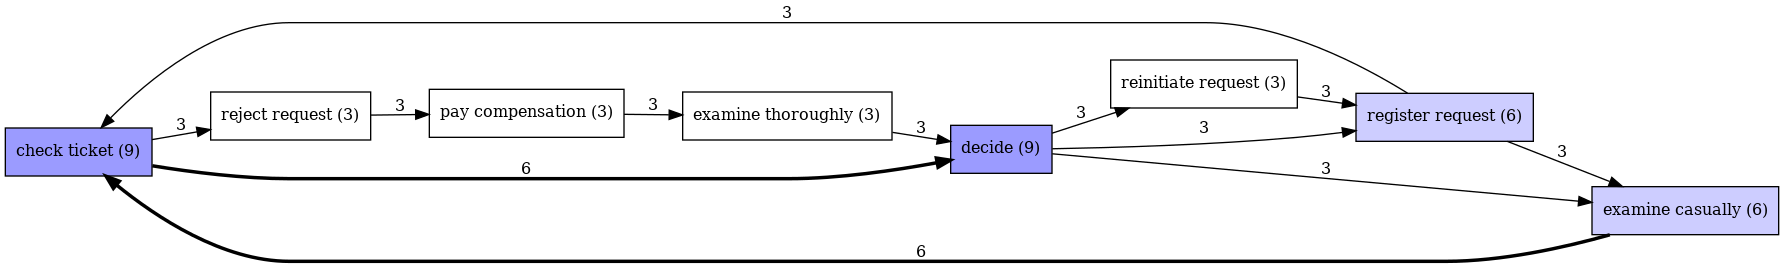

In [62]:
gviz_freq = dfg_visualizer.apply(frequency_dfg, variant=dfg_visualizer.Variants.FREQUENCY, activities_count=activities_freq)
dfg_visualizer.view(gviz_freq)

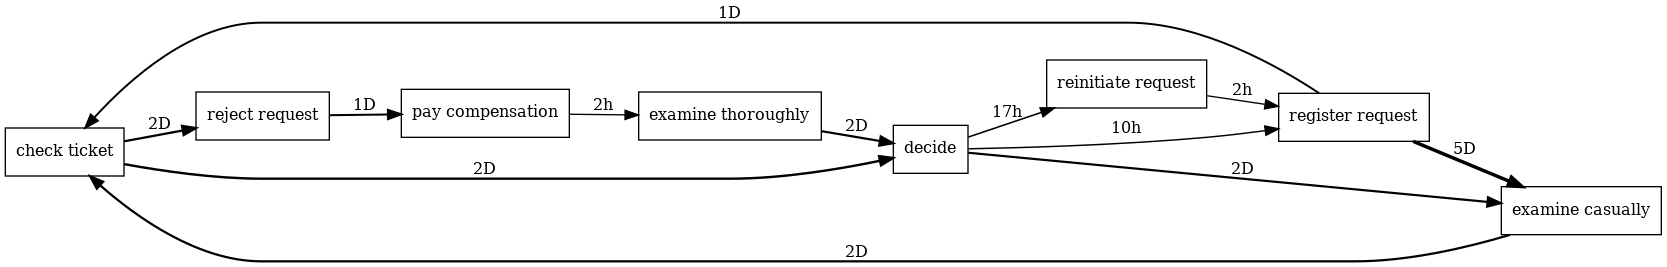

In [63]:
gviz_perf = dfg_visualizer.apply(performance_dfg, variant=dfg_visualizer.Variants.PERFORMANCE, activities_count=activities_freq)
dfg_visualizer.view(gviz_perf)

<br></br>
# <b>Resources:</b>
- PM4PY [documentation](https://pm4py.fit.fraunhofer.de/documentation)
- PM4Py [documentation](http://pm4py.pads.rwth-aachen.de/documentation/) (older version)
- Towards Data Science story [Introduction to Process Mining](https://towardsdatascience.com/introduction-to-process-mining-5f4ce985b7e5)
- Process Mining for Python on [Youtube](https://www.youtube.com/channel/UCRcgOKrDsntrTI78RXXliuw/videos)
- Wikipedia page [process mining](https://en.wikipedia.org/wiki/Process_mining)
- Wikipedia page [Petri net](https://en.wikipedia.org/wiki/Petri_net)
- Alpha Miner [video](https://www.futurelearn.com/info/courses/process-mining/0/steps/15636)
- Heuristics Miner [video](https://www.futurelearn.com/info/courses/process-mining/0/steps/15639)
- Inductive Miner [video](https://www.futurelearn.com/info/courses/process-mining/0/steps/15642)
- Workflow Net and Soundness [video](https://www.coursera.org/lecture/process-mining/2-5-workflow-nets-and-soundness-tBnqo)
- Process Mining Manifestio ([pdf-document](https://www.win.tue.nl/ieeetfpm/downloads/Process%20Mining%20Manifesto.pdf))
- Data Mining [Event Logs](https://data.4tu.nl/search?q=BPI)
